**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
November 13, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

# **Assignment 2: “Sequence Models”**
**Due**: Monday, November 27, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: Part-of-Speech Tagging with a Bidirectional LSTM**  (2+4+5=11 points)

In this task we will be building a sequence tagger that produces an output for every element in an input sequence, using `PyTorch` and `TorchText`, where `TorchText` consists of data processing utilities and popular datasets for natural language.


*   **input:** a sequence of text
*   **output:** part-of-speech (POS) tag for each token in the input text

We tackle this task using a multi-layer bi-directional LSTM (BiLSTM) to predict POS tags using the [Universal Dependencies](https://universaldependencies.org/) English Web Treebank (UDPOS) dataset. This dataset is contained in the `TorchText` library and we do not require an external file for it. The dataset in  `TorchText`  has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We only focus on the UD tags for this assignment.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from torchtext.datasets import UDPOS

import numpy as np

import time
import random
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# for reproducibility
random.seed(77)
np.random.seed(77)
torch.manual_seed(77)
torch.backends.cudnn.deterministic = True

### Subtask 1: Data Analysis
The very basic components of the torchtext library include `vocab`, `word vectors`, and `tokenizer`. Those are the basic data processing building blocks for the raw text string.
In this case, we use the tokenizer and the vocabulary. Use the `build_vocab_from_iterator` to create the vocabulary for the text field and add the `<unk>` and `<pad>` tokens to it. Use a minimal frequency of `2`.
Also create a vocabulary for the labels (tag field). However, since the tags are predefined elements, you will not need an `<unk>` token.
 This dataset actually has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We train our model on the UD tags, which is the second element on the list of outputs (example below).


In [2]:
train_iter = iter(UDPOS(split="train"))
print(next(train_iter))

[['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.'], ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], ['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']]


In [3]:
print(f"Number of training examples: {len(list(UDPOS(split='train')))}")
print(f"Number of validation examples: {len(list(UDPOS(split='valid')))}")
print(f"Number of testing examples: {len(list(UDPOS(split='test')))}")

Number of training examples: 12543
Number of validation examples: 2002
Number of testing examples: 2077


Note that the data is already tokenized!

In [4]:
# Create vocabularies
def yield_tokens(data_iter, field):
    for item in data_iter:
        if field == 'text':
            yield item[0]
        elif field == 'ud_tags':
            yield item[1]

# Reset the iterator for text
train_iter = UDPOS(split="train")

# Create vocabulary for text
vocab = build_vocab_from_iterator(yield_tokens(train_iter, 'text'), specials=["<pad>", "<unk>"], min_freq=2, special_first=True)
vocab.set_default_index(vocab['<unk>'])

# Reset the iterator for UD tags
train_iter = UDPOS(split="train")

# Create vocabulary for UD tags, ensuring <pad> is first in the list of specials
ud_vocab = build_vocab_from_iterator(yield_tokens(train_iter, 'ud_tags'), specials=["<pad>"], special_first=True)
ud_vocab.set_default_index(ud_vocab['<pad>'])

Prepare a text processing pipeline that takes raw input and labels and converts them to ids.

In [5]:
text_pipeline = lambda x: vocab(x)
label_pipeline = lambda x: ud_vocab(x)

In [6]:
print(text_pipeline(['the', 'preacher', 'at', 'mosque', "<pad>","pppp"])) #should output [3, 9271, 35, 9097, 0, 1]
print(label_pipeline(['DET', 'ADJ', 'NOUN', 'PUNCT'])) # should output [6, 8, 1, 2]

[3, 9271, 35, 9097, 0, 1]
[6, 8, 1, 2]


In [7]:
print(f"Unique tokens in input vocabulary: {len(vocab)}")
print(f"Unique tokens in UD vocabulary: {len(ud_vocab)}")

Unique tokens in input vocabulary: 9875
Unique tokens in UD vocabulary: 18


Write a custom function for the dataloader that applies the text and label pipeline and pads the sequences to have equal lengths.

In [8]:
from functools import partial

def collate_batch(batch, text_pipeline, label_pipeline, pad_token_ix, pad_token_ix_ud):
    text_list, label_list = [], []
    for item in batch:
        _text, _label, _ = item  # ignore PTB label
        processed_text = text_pipeline(_text)
        processed_label = label_pipeline(_label)
        text_list.append(torch.tensor(processed_text, dtype=torch.int64))
        label_list.append(torch.tensor(processed_label, dtype=torch.int64))

    x_padded = pad_sequence(text_list, batch_first=True, padding_value=pad_token_ix)
    y_padded = pad_sequence(label_list, batch_first=True, padding_value=pad_token_ix_ud)

    return x_padded, y_padded


collate_fn = partial(collate_batch, text_pipeline=text_pipeline, label_pipeline=label_pipeline, pad_token_ix=vocab['<pad>'], pad_token_ix_ud=ud_vocab['<pad>'])

train_dataloader = DataLoader(
    UDPOS(split="train"), batch_size=128, shuffle=True, collate_fn=collate_fn
)
valid_dataloader = DataLoader(
    UDPOS(split="valid"), batch_size=128, shuffle=True, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    UDPOS(split="test"), batch_size=128, shuffle=True, collate_fn=collate_fn
)

In [9]:
for idx, (label, text) in enumerate(train_dataloader):
      print(label.shape)
      print(text.shape)
      print(label[0])
      print(text[0])
      break
print('### Valid_dataloader ###')
for idx, (label, text) in enumerate(valid_dataloader):
      print(label.shape)
      print(text.shape)
      print(label[0])
      print(text[0])
      break


torch.Size([128, 57])
torch.Size([128, 57])
tensor([1832,   13,   17,  488, 2837,    3, 3074,    1, 5532,  512,   13,   23,
          56,  143,    5,  170,  154,  273,   39,  157,  971,   44, 2212,  648,
           2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor([14,  4,  9, 12,  3,  6,  1,  1, 10, 17,  4,  3, 10, 13,  5, 13,  1, 10,
        14,  9,  3,  5,  7,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0])
### Valid_dataloader ###
torch.Size([128, 41])
torch.Size([128, 41])
tensor([   1, 3633,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
   

Let's take a closer look at the data and the distribution of tags.
Implement `tag_percentage`:

*   Use the `collection.counter` to count the unique instances of each tag.

*    Compute the percentage of each tag in the entire set, by using the counted frequencies.



In [10]:
from collections import Counter

def tag_percentage(training_iterator):
    counter = Counter()
    #### code to count the number of tags
    for item in training_iterator:
        text, ud_tags, ptb_tags = item  # 分别获取文本、UD标签和PTB标签
        counter.update(ud_tags)  # 只计算UD标签

    total_tags = sum(counter.values())

    ### compute the tag percentages based on the counter object

    tag_p = [(tag, count, count / total_tags) for tag, count in counter.items()]
    ###
    return tag_p

In [11]:
print("Tag\t\tCount\t\tPercentage\n")

for tag, count, percent in tag_percentage(UDPOS(split='train')):
    print(f"{tag}\t\t{count}\t\t{percent*100:4.1f}%")

Tag		Count		Percentage
PROPN		12946		 6.3%
PUNCT		23679		11.6%
ADJ		12477		 6.1%
NOUN		34781		17.0%
VERB		23081		11.3%
DET		16285		 8.0%
ADP		17638		 8.6%
AUX		12343		 6.0%
PRON		18577		 9.1%
PART		5567		 2.7%
SCONJ		3843		 1.9%
NUM		3999		 2.0%
ADV		10548		 5.2%
CCONJ		6707		 3.3%
X		847		 0.4%
INTJ		688		 0.3%
SYM		599		 0.3%


####${\color{red}{Comments\ 1.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
✅ Point distribution so far ✅

- 0.25 / 0.25 points if the example outputs align with solution, if the ids do not match because the id of `<pad>`,`<unk>` are different, assign the points.

The solution is  a little bit different in how th methods are constructed (2 methods instead of 1 for yielding tags and tokens) but it is practically the same with the correct output

- 0.25 / 0.25 points if len(input_vocab)=9875 and len(ud_vocab)=18, showing that the tokens were added correctly.

The output is correct

- 0.25 / 0.25 points if the special tokens are set correctly.

The implementation so far is identical, the special tokens are set at the beginning. 

- 0.25 / 0.25 points if the batch size of the output example is 128.

Batch size is identical

- 0.5 / 0.5 points if the output is correctly converted to indices and tensors and the function is correct.

The functions differes slightly implementationwise ( classic for loop instead of enumeration and usage of helper lists ), but it is identical with the correct output. The sample solution is a bit more elgeant because it uses less code. Only real difference is the print for the validation set as well, that was performed here, which has no effect on the grading


- 0.5 / 0.5 points if the largest portion of data is NOUN with 34781 counts and 17.0%, and at the bottom is SYM with 599 counts and 0.3% and the logic is correct.

Correctly counted everything, the logic is also identical.


Overall points for subtask 1: 
 2 / 2 Points

```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: The Model

We start by creating a simple model and then make it more complex in later subtasks. The class `BiLSTMTagger` must subclass the `nn.Module` class of `PyTorch`. Fill the blank in the class by following the notes described below.
1.   The input is a sequence of tokens, $X = \{x_1, x_2,...,x_T\}$.
2.   Each token passes through  an embeddings layer, $e(X) = \{e(x_1), e(x_2), ..., e(x_T)\}$. Use `nn.Embedding` for the embedding layer and make sure to pass in the index of the pad token.
3. Embedding is processed by forward and backward LSTMs from left to right and right to left.  The first input to the forward LSTM is $x_1$ and the first input to the backward LSTM is $x_T$. The hidden state of LSTMs is dependent on
the hidden, $h$, and cell, $c$, states from the previous time-steps:
$$h^{\rightarrow}_t = \text{LSTM}^{\rightarrow}(e(x^{\rightarrow}_t), h^{\rightarrow}_{t-1}, c^{\rightarrow}_{t-1})$$
$$h^{\leftarrow}_t=\text{LSTM}^{\leftarrow}(e(x^{\leftarrow}_t), h^{\leftarrow}_{t-1}, c^{\leftarrow}_{t-1})$$
4. The hidden, $h$, and cell, $c$ of each layer is passed to the next layer, where the $h_0$ and $c_0$, for each direction and layer, are initialized to a tensor full of zeros. Use `nn.LSTM` for LSTM cells. How can you make it bidirectional?
5. Final hidden state is the concatenation of forward and backward hidden states from the final layer of the LSTM, $H = \{h_1, h_2, ... h_T\}$, where $h_1 = [h^{\rightarrow}_1;h^{\leftarrow}_T]$, $h_2 = [h^{\rightarrow}_2;h^{\leftarrow}_{T-1}]$. Use `nn.Linear` here.
6. The last layer is linear layer $f$, which is used to make the prediction of which tag applies to this token, $\hat{y}_t = f(h_t)$.
7. Define a `nn.Dropout` layer to apply to the embeddings and the outputs of the final layer of the LSTM.

In [12]:
import torch
import torch.nn as nn

class BiLSTMTagger(nn.Module):
    def __init__(self, hyperparameters):
        '''
        hyperparameters: is a dictionary containing:
            input_dim: dimension of the input
            embedding_dim: dimension of the embedding layer
            lstm_hidden_dim: dimension of the hidden state of lstms
            output_dim: dimension of the output hidden layer
            n_layers: number of layers to stack
            bidirectional: is the lstm bi-directional
            dropout: probability for the drop out layer
            pad_idx: id of the pad token
        '''
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=hyperparameters['input_dim'],
            embedding_dim=hyperparameters['embedding_dim'],
            padding_idx=hyperparameters['pad_idx']
        )

        # Bi-LSTM, apply dropout if the number of layers is more than 1
        self.lstm = nn.LSTM(
            input_size=hyperparameters['embedding_dim'],
            hidden_size=hyperparameters['lstm_hidden_dim'],
            num_layers=hyperparameters['n_layers'],
            bidirectional=hyperparameters['bidirectional'],
            dropout=hyperparameters['dropout'] if hyperparameters['n_layers'] > 1 else 0
        )

        # Linear layer for prediction
        self.fc = nn.Linear(
            in_features=hyperparameters['lstm_hidden_dim'] * 2 if hyperparameters['bidirectional'] else hyperparameters['lstm_hidden_dim'],
            out_features=hyperparameters['output_dim']
        )

        # Dropout layer
        self.dropout = nn.Dropout(hyperparameters['dropout'])

    def forward(self, text, debug=False):  # (B,S)
        '''
        S: sentence len
        B: batch size
        E: embedding size
        H: hidden size
        O: output size
        L: number of layers
        '''

        # Pass text through the embedding layer and a dropout layer
        embedded = self.dropout(self.embedding(text))

        # Pass embeddings into Bi-LSTM
        outputs, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final hidden states from both directions if bidirectional
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]

        # Compute prediction
        predictions = self.fc(hidden)

        if debug:
            print("Input shape:", text.shape)
            print("Embedding shape:", embedded.shape)
            print("LSTM output shape:", outputs.shape)
            print("LSTM hidden shape:", hidden.shape)
            print("LSTM cell shape:", cell.shape)
            print("Output shape:", predictions.shape)

        return predictions


Response in plain text:
1. Based on the notation defined in the forward function. What is the dimension of `outputs`, `hidden`, and `cell`?

In [13]:
hyper_parameters={
  'input_dim':  len(vocab),
  'embedding_dim': 100,
  'lstm_hidden_dim': 128,
  'output_dim':len(ud_vocab),
  'n_layers': 2 ,
  'bidirectional':True,
  'dropout': 0.25,
  'pad_idx': vocab['<pad>']
}
model = BiLSTMTagger(hyper_parameters)

In [14]:
input=torch.tensor([[3, 9271, 35, 9097, 0, 1],
                    [3, 9271, 35, 9097, 0, 1]])
model(input,debug=True).shape

print("pad_idx:", hyper_parameters['pad_idx'])

Input shape: torch.Size([2, 6])
Embedding shape: torch.Size([2, 6, 100])
LSTM output shape: torch.Size([2, 6, 256])
LSTM hidden shape: torch.Size([6, 256])
LSTM cell shape: torch.Size([4, 6, 128])
Output shape: torch.Size([6, 18])
pad_idx: 0


Weights of the network are initialized randomly, so let's make a more systematic initialization to help us with the optimization. For example,  Xavier Initialization creates weights such that the variance of the activations is the same across every layer. This constant variance helps prevent the gradient from exploding or vanishing. However, it does not apply to bias terms.

Create a function that uses Xavier Initialization to initialize the weights of the network, for biases use a normal distribution with a mean of 0 and a standard deviation of 0.1.

In [15]:
import torch.nn.init as init

def init_weights(m):
    if type(m) == nn.Linear:
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.normal_(m.bias, mean=0, std=0.1)
    elif type(m) == nn.Embedding:
        init.xavier_uniform_(m.weight)

# Applying the initialization to the model
model.apply(init_weights)
model.to(device)

BiLSTMTagger(
  (embedding): Embedding(9875, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Let's count the number of trainable parameters in our model.

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("number of trainable parameters:",count_parameters(model))

number of trainable parameters: 1622910


####${\color{red}{Comments\ 1.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
✅ Point distribution so far ✅
- 0 / 0.25 points if the output shape is correct
- 0 / 0.25 points if the hidden and cell shapes are correct from the question.

Sadly, I think this has been overlooked by the team, because the markdown is empty, hence 0/ 0.5 points. But as feedback: It would be nice of the ones creating the assignments to highlight such cells better, because it is quite easy to overlook that you need to do something there. 


✅ Point distribution ✅
- 0.666 / 1 point if the output shapes are correct:

Input shape: torch.Size([2, 6])
Embedding shape: torch.Size([2, 6, 100])
LSTM output shape: torch.Size([2, 6, 256])
LSTM hidden shape: torch.Size([4, 6, 128])
LSTM cell shape: torch.Size([4, 6, 128])
Output shape: torch.Size([2, 6, 18])

this one is duplicated with the last shape above, hence follow up error which is disregarded by me --> torch.Size([2, 6, 18])


Not all elements are correct. The LSTM hidden shape and the output shapes are incorrect. The bidirectionality was not implemented correctly, hence the error. Since there are 6 values (as explained above instead of 7) for 1 point and 4/6 are correct. this makes up for 0.666 Points

- 0.5 / 1 point check the layers, if the bi-directionality and dropout are correct and all the elements are in place.

As explained above bidirectionality was not implemented correctly. I don't understand what all elements are in place means, but I cannot ay that I see a misplaced element, hence 0.5 / 1 Point


- 0.25 / 0.5 points if the forward function is implemented correctly

The forward function is implemented correctly, but not regarding the bidirectionality. The concatenation approach for the bidirectionality is not needed and shouldn't be implemented. This is also the root cause for the errors described above. Overall a solid forward function though --> 0.25 / 0.5



Overall points for Subtask 2:

1.416 / 3 Points 



```

${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Training

We start by defining a loss function and an optimizer.


*   **optimizer:** We use Adam with the learning rate=0.0001.
*   **loss:** We use cross-entropy loss.

Even though we have no `<unk>` tokens within our tag vocab, we still have `<pad>` tokens to create batches of the same size. However, we do not want to calculate loss on those tokens, so make sure you define your loss function in such a way that ignores the `<pad>` tokens.




In [17]:
import torch.nn.functional as F

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Loss function (ignores <pad> tokens)
pad_idx = hyper_parameters['pad_idx']
loss_function = nn.CrossEntropyLoss(ignore_index=pad_idx)

✅ Point distribution ✅
- 0.25/0.25 points if the optimizer is defined correctly
- 0.25/0.25 points if the loss is defined correctly

Watching the loss go down as you train a model is a good indication of the correct training procedure, but does not tell us how well we are doing on a given task.
To this end, we also implement a categorical accuracy measure to keep track of how well our model is doing on a given task.
Same as before: we don't want to calculate accuracy over the `<pad>` tokens as we aren't interested in predicting them.
Implement the function `categorical_acc` to compare the prediction of non-pad tokens with labels count the correct ones and calculate the accuracy over a single batch.

In [18]:
def categorical_acc(preds, gt, pad_idx):
    """
    Returns categorical accuracy per batch
    """
    # Get the index of the max probability
    max_preds = preds.argmax(dim=1)

    # Mask positions where the ground truth is not <pad>
    non_pad_positions = gt != pad_idx

    # Count the correct predictions where the ground truth is not <pad>
    correct = (max_preds[non_pad_positions] == gt[non_pad_positions]).sum().item()

    # Count the total number of non-pad tokens
    total_non_pad = non_pad_positions.sum().item()

    # Calculate accuracy
    accuracy = correct / total_non_pad if total_non_pad > 0 else 0

    return accuracy


In [19]:
dummpy_input=torch.tensor([
    [0.9,0,0,0],
    [0.1,0.9,0,0],
    [0.1,0,0,0.9],
    [0.9,0.1,0,0],
    [0.1,0.8,0,0]

])
categorical_acc(dummpy_input, torch.tensor([0,2,3,0,1]), 0)

0.6666666666666666

✅ Point distribution ✅
- 0.5/0.5 points if the function is correct, the output should be `0.6667`, if not check the function code to find error and give partial grade.

Define the `train` model that performs one epoch of training. You can refer to the Tutorial 2 of the course to get a sample workflow. The only difference to the tutorial is that we keep track of the batch-wise accuracy as well as the loss.

In [20]:
def train(model, dataloader, optimizer, loss_function, pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.train()
    epoch_start_time = time.time()

    for length_dataloader,(text,tags) in enumerate(dataloader):
        # zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(text)

        # compute the loss, ignoring <pad> token
        loss = loss_function(predictions.view(-1, predictions.shape[-1]), tags.view(-1))

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Compute categorical accuracy
        acc = categorical_acc(predictions, tags, pad_idx)

        # Update epoch loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc
        
    end_time= time.time() - epoch_start_time
    return epoch_loss / length_dataloader, epoch_acc / length_dataloader,end_time

✅ Point distribution ✅
- 1/1 
- 0.25/0.25 points if the loss function is called correctly
- 0.25/0.25 points if the loss and accuracy are accumulated properly
It is ok to divide by length_dataloader or length_dataloader+1.

It is not enough to only look at the training loss and accuracy, since with more training, we can always do better on the training set, but lose the generalizability to unseen data, a phenomenon known as **overfitting**. Therefore, it is important to check the loss and accuracy on the validation set after each epoch and stop before  overfitting occurs. Moreover, we can use the validation metric as an indication of which checkpoint of our model is the best.

Define an `evaluate` function that runs once through the validation set and computes loss and accuracy. **Note:** You should not be updating gradients here and your model should be in evaluation mode.

In [23]:
def evaluate(model, dataloader, loss_function, pad_idx):
    val_loss = 0
    val_acc = 0

    model.eval()  # Set the model to evaluation mode
    length_dataloader = len(dataloader)

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch_num, (text, tags) in enumerate(dataloader):
            # Forward pass
            predictions = model(text)

            # Flatten predictions and targets, excluding padded elements
            predictions_flat = predictions.view(-1, predictions.shape[-1])
            tags_flat = tags.view(-1)

            # Mask out padded elements
            non_pad_elements = (tags_flat != pad_idx).nonzero().squeeze()

            # Compute the loss, ignoring <pad> tokens
            loss = loss_function(predictions_flat[non_pad_elements], tags_flat[non_pad_elements])

            # Compute categorical accuracy
            acc = categorical_acc(predictions_flat[non_pad_elements], tags_flat[non_pad_elements], pad_idx)

            # Update validation loss and accuracy
            val_loss += loss.item()
            val_acc += acc

    return val_loss / length_dataloader, val_acc / length_dataloader


✅ Point distribution ✅
- 0.25/0.25 points if the `model.eval()` is used and the block is in `torch.no_grad()`
- 0.5/0.5 points if the rest of the function is correct (should be similar to the one above)

Let's use the functions defined so far and train our model for `30` epochs. We suggest using GPU for this task, as it is quite slow on the CPU. Run the training loop for the given number of epochs and calculate the validation metric at the end of each epoch. Based on the validation loss, save the best checkpoint of the model.

In [24]:
epochs = 30

best_valid_loss = float('inf')
print("pad_idx:", hyper_parameters['pad_idx'])


for epoch in range(epochs):
    # Training
    train_loss, train_acc, epoch_time = train(model, train_dataloader, optimizer, loss_function, hyper_parameters['pad_idx'])

    # Validation
    valid_loss, valid_acc = evaluate(model, valid_dataloader, loss_function, hyper_parameters['pad_idx'])

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
    elapsed_mins = int(epoch_time / 60)
    elapsed_secs = int(epoch_time - (elapsed_mins * 60))
    print(f'Epoch: {epoch+1:02} | Epoch Time: {elapsed_mins}m {elapsed_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Validation Loss: {valid_loss:.3f} |  Validation Acc: {valid_acc*100:.2f}%')


print("pad_idx:", hyper_parameters['pad_idx'])


pad_idx: 0


ValueError: Expected input batch_size (54) to match target batch_size (6912).

✅ Point distribution ✅
- 0/0.25 points if the training and validation loop are correctly called
- 0/0.25 points if the best checkpoint is one that is saved

Question:

1. Does overfitting occur? If so, after which epochs?

2. How do you detect overfitting?


**Answer:**
```
In our case there was a value mismatch error resulting in us not able to analyze the code properly
```

✅ Point distribution ✅
- 0/0.25 points for 1
- 0/0.25 points for 2

Let's see how well our model is doing on the test set. Load the best checkpoint and calculate the accuracy.

In [23]:
#### you code ####

#### you code ####
test_acc

NameError: name 'test_acc' is not defined

####${\color{red}{Comments\ 1.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
Overall points: 3.25/4.25

Sadly they overlooked, that they could have still described what overfitting is without actual results of the model. 
The training and model steps are all very close to the sample-solution. They just didn't work with the sizes of input batch and output batch correctly. 
Their error "ValueError: Expected input batch_size (54) to match target batch_size (6912)." shows, that they didn't flatten the inputs correctly for the loss function. 
6912/128 = 54. This shows, that they tried to evaluate on the entire batch (128) and not just each 54 token long sequence. 
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4: Inference

Let's use the model we trained to tag some actual sentences. We have the preprocessing pipeline ready from Subtask 1, now we need to map the predictions back to label texts for each token.

Implement the `tag_sequence` function that takes a model and a sentence as input and generates POS tags. Keep in mind that you need to divide the sentence into tokens first. For this purpose, we just split each sentence on whitespaces.

In [24]:
def tag_sentence(model, sentence):
    ### your code ###


    predictions = # make predictions on th esentence


    predicted_tags = # get the tags
    ### your code ###
    return predicted_tags

SyntaxError: invalid syntax (358943157.py, line 5)

In [25]:
text=" ".join(list(UDPOS(split='test'))[0][0])
label= list(UDPOS(split='test'))[0][1]
predicted_tag=tag_sentence(model,text)
print("Text: ",text)
print("Predicted Tags: ",predicted_tag)
print("True Tags: ",label)

NameError: name 'tag_sentence' is not defined

✅ Point distribution ✅
- 0/0.5 no inference possible because model was not working

####${\color{red}{Comments\ 1.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
Overall points: 0/0.5

Subtask 4 not done. 
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 2: Theoretical Questions** (0.5+1.5+1+3=6 points)

### Subtask 1:
In beam search, if you increase the beam width, what will happen to a) the runtime and memory and b) the quality of results?

**Answer:**


a) Running time and memory usage: Increasing the beam width means that during the search process, the algorithm needs to track and calculate more candidate solutions simultaneously. This naturally increases the computational burden of the algorithm, resulting in longer running times. At the same time, memory usage will increase accordingly as more candidate solutions need to be stored. In short, increasing beam width results in increased runtime and memory usage.

b) Quality of results: Increasing the beam width usually improves the quality of the solutions found. This is because the algorithm has more room to explore different possibilities, reducing the risk of missing good solutions due to early pruning. However, this is not always proportional, as in some cases increasing beam width may only bring marginal improvement. Furthermore, in some specific cases, a beam that is too wide may even lead to a decrease in search efficiency, as the algorithm may spend unnecessary time exploring low-quality solutions.

####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
Very extensive and intuitive answers. Message is the same as in sample solution.

0.25/0.25 for a
0.25/0.25 for b
```


${\color{red}{⚠️Comments\ end⚠️}}$


### Subtask 2:
Except for beam search, there are other ways to create a more coherent output for generation tasks, one of which is adding a temperature to the softmax over the vocabulary. Temperature is a hyperparameter that is applied to the input of a softmax to affect the final probabilities. All values in the input are divided by the temperature before going through the softmax. What do you think will happen in these cases:

1. A low temperature - below 1
2. A high temperature - above 1
3. Really small temperature - temperature $→$ 0

**Answer:**

 **Low temperature (below 1)**: When the temperature value is lower than 1, it amplifies the difference in the input vector. This means that even small differences become more noticeable. In the softmax output, the items with the highest probability will become more prominent, while the probabilities of other items will be relatively reduced. Therefore, low temperatures will bias the model's output toward selecting the words with the highest probability, resulting in more deterministic, less stylized text generation. This helps improve the consistency and predictability of the output, but may reduce text variety.

**High temperature (above 1)**: When the temperature value is higher than 1, it reduces the difference in the input vector. This will make the probability distribution of the softmax output more uniform, and even items with lower probabilities will have a higher probability of being selected. Therefore, high temperatures will cause the generated text to become more diverse and unpredictable, but at the same time may sacrifice some consistency and accuracy.

**Really small temperatures (temperature → 0):** As the temperature approaches 0, the behavior of the model becomes extreme. In practice, this causes the softmax output to almost always select the word with the highest score, since the probability of all other options will approach zero. In this case, the generated text will be very deterministic and repetitive, almost always selecting the same sequence of words, severely limiting the diversity and creativity of the text.

####${\color{red}{Comments\ 2.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
Behaviour and text characteristics are described correctly. For subtask 3 the similarity to greedy decoding is not mentioned as in the smaple solution. Nevertheless, the answers absolutely sufficient.

- 0.5/0.5 for 1
- 0.5/0.5 for 2
- 0.5/0.5 for 3
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3:
Explain what the “bottleneck” of an encoder-decoder RNN is and how attention provides a way to get around this bottleneck.

**Answer:**

In the encoder-decoder (Encoder-Decoder) recurrent neural network (RNN) structure, the "bottleneck" refers to a restriction point in the flow of information. This structure is often used for sequence-to-sequence tasks such as machine translation, where the encoder converts the input sequence (such as a sentence) into a fixed-size internal representation (or called a context vector), and then the decoder uses this internal representation to generate the output sequence.

**Bottleneck problem**:

- **Fixed size internal representation**: The encoder compresses all input information into a fixed size vector. For longer input sequences, this fixed-size vector may not capture all important information efficiently, especially when the sequence is very long.
- **Information Loss**: As sequence length increases, the encoder may lose information about the beginning of the input sequence when creating an internal representation, which can negatively impact the decoder's ability to produce accurate and relevant output.

**Attention Mechanism (Attention)**:

Attention mechanisms provide a way to solve the encoder-decoder bottleneck. It allows the decoder to "focus" (or weight) on different parts of the encoder's output at each step in generating the output. The core idea of this mechanism is to selectively focus on certain parts of the input sequence at each decoding step, rather than relying only on a fixed context vector.

- **Dynamic Context**: The attention mechanism allows the decoder to take into account the entire range of the input sequence when generating each word, rather than relying only on a single, static context vector. In this way, the decoder can extract more relevant information from the input sequence.
- **Improved long-distance dependencies**: The attention mechanism is particularly useful when dealing with long sequences, as it allows the model to directly access distant elements in the input sequence, thus handling long-distance dependencies more effectively.
```

####${\color{red}{Comments\ 2.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
Absolutely correct! Even sebarated and structured explanations for partial problems (dynamic context and long-distance dependencies) which are summarised in one sentence of the sample solution.
1/1 points
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4:
As mentioned, there are various way to remedy the repetitiveness and incoherence of generation outputs. One of the widely used methods is Nucleus sampling described the paper "[ The Curious Case of Neural Text DeGeneration](https://arxiv.org/pdf/1904.09751.pdf)". Read the model section and introduction of the paper and use it as reference to answer the following questions:

1. Describe top-k sampling in your own words, no need for mathematical notation.
2. Describe Nucleus sampling in your own words, there is not need for mathematical notation.
3.  Why is beam search not a good strategy for human-like text generation and why don't these methods suffer from the problem of the beam search?


**Answer:**


**Beam Search Problem**:
- Beam search optimizes for high-probability output, which sounds reasonable because we expect good models to assign higher probabilities to human-like, grammatically correct text. But in practice, this approach often produces generic, repetitive, and clunky results when generating long texts. Beam search produces text that differs significantly in probability assignments from naturally occurring text, which results in poor output quality.

**Top-k sampling**:
- In top-k sampling, each time a word is generated, the model randomly selects one from the k words with the highest probability. Rather than simply selecting the most likely words, this approach adds randomness to words with higher probability, thereby increasing text diversity and creativity.

**Nucleus Sampling**:
- Nucleus sampling is a more refined sampling method that takes into account the cumulative probability distribution of vocabulary. In this approach, instead of selecting from a fixed number of words, the model selects a "core" set that contains words whose sum of probabilities reaches a certain threshold. This threshold is usually a percentage, meaning that the set of words selected changes dynamically based on the context. Doing so balances diversity and accuracy because it takes into account the model's "confidence" in the current situation

Compared with beam search, these sampling methods are not restricted by selecting the most likely words, so they better capture the diversity and creativity of the text and avoid problems of repetition and unnaturalness. These methods get closer to the characteristics of human text generation by introducing randomness and diversity while maintaining language fluency.```

####${\color{red}{Comments\ 2.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
- Top-K sampling word correctly described. In contrast to the sample solution, which refers to the tail, the solution explains the subset that is sampled from.
- Very intuitive explanation. Sample solution uses p to explain the algorithm.
- Intuitive explanation. Nevertheless it is not described, why the two previous approaches do not suffer from the problem.


- 1/1 point for 1
- 1/1 point for 2
- 1/1 point for 3
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 3: Scaled Dot-Product Attention** (4+1=5 points)
In class, you learned about attention and Transformers as described in the 2017 paper
[Attention Is All You Need](https://arxiv.org/abs/1706.03762).
The base of the attention module is a scaled dot product with Queries, Keys, and Values.
In this task, you will implement a simplified version of scaled dot-product attention and inspired by the translation task, aim to replicate word alignment between English and French.
You will not be training the embedding from scratch, we provide you with pre-trained embedding for both languages.
However, you need to know the details of scaled dot product attention, which mainly consists of two matrix multiplications and a softmax scaling.
Refer to Figure 2 of the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper.

The inputs of the attention module are Queries, Keys, and Values. Mathematically, attention is defined as follows:

$$
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$


*   $Q$, $K$, and $V$ are the Queries, Keys, and Values matrices.
* $d_k$ is the dimension of the Keys (in practice dimensions of all matrices are the same).
*   $QK^{\top}$ is a measure of the similarity between the Queries and the Keys
* softmax transforms the similarity into weights.
* Weights multiplied by the Values are the output of the attention, defining how much importance should be given to each token of the input.

In the case of self-attention, both Queries and Keys come from the encoder, however, for cross attention between encoder and decoder, decoder states are used as the queries while encoder states are the Keys and Values.
In our case, we need the cross attention between one language to another to find the correct alignment.


In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
#load the dictionaries (dictionary of words to ids)
with open("./word2int_en.pkl", "rb") as f:
    en_dict = pickle.load(f)

with open("./word2int_fr.pkl", "rb") as f:
    fr_dict = pickle.load(f)

# load word embeddings (dictionary of token ids to embeddings)
en_embeddings = np.load("./embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./embeddings_fr.npz")["embeddings"]


### Subtask 1: Attention Weights
Fill the blanks in `tokenize` to tokenize a sentence and convert it to ids and `embed` function to create an embedding of a sentence.

In [2]:
def tokenize(sentence, token_mapping):
   # we stick to simple blank space tokenization
   tokenized = []
   for word in sentence.lower().split(" "):
      ### your code ###
      # Check if the word is in the token mapping, else use a special token for unknown words, e.g., "<unk>"
      token_id = token_mapping.get(word, token_mapping.get("<UNK>", None))
      if token_id is None:
            # Handle the case where "<UNK>" is also not in the dictionary
          continue  # Skip this word or you can choose to append a specific ID for unknown words
      tokenized.append(token_id)
      ### your code ###
   return tokenized

def embed(tokens, embeddings):
    """ get the embedding for the tokens in a sentence stacked in a simple matrix (sequence length, embedding size)
        tokens: tokenized sentence
        embeddings: dictionary of token to embeddings.
    """
    embed_size = embeddings.shape[1]
    output = np.zeros((len(tokens), embed_size))

    for i, token_id in enumerate(tokens):
        if token_id is not None and 0 <= token_id < len(embeddings):
            output[i] = embeddings[token_id]
        else:
            output[i] = np.zeros(embed_size)
    return output

In [3]:
sentence_en = "there were clouds in my coffeeeeee."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)
print("Tokenized english:",tokenized_en)
print("embedding english:",embedded_en.shape)

sentence_fr = "il y avait des nuages ​​dans mon ccafé."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)
print("Tokenized french:",tokenized_fr)
print("embedding french:",embedded_fr.shape)

Tokenized english: [59, 40, 9355, 6, 158]
embedding english: (5, 300)
Tokenized french: [21, 73, 192, 16, 8652, 558]
embedding french: (6, 300)



Implement the `softmax` function with `Numpy`.


In [4]:
def softmax(x, axis=0):
    """
    x: input matrix
    axis: defines which axis to compute the softmax over 0 for rows and 1 for columns
        axis=0 calculates softmax across rows which means each column sums to 1
        axis=1 calculates softmax across columns which means each row sums to 1
    """

    # Shift the input x by subtracting its max value for numerical stability
    x_shifted = x - np.max(x, axis=axis, keepdims=True)

    # Exponentiate the shifted values
    exp_x = np.exp(x_shifted)

    # Normalize by the sum along the specified axis
    softmax_x = exp_x / np.sum(exp_x, axis=axis, keepdims=True)

    return softmax_x

In [5]:
w=softmax(np.array([[1,3,4,1], [24,3,2,3]]),axis=0)
w.sum(axis=0)[0]

1.0

Use the `softmax` function to calculate the weights.
$$ \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)$$
Assume the queries and keys are 2D matrices.

In [6]:
def calc_weights(queries, keys):
    """
    queries: queries matrix
    keys: keys matrix
    """

    dk = keys.shape[1]  # Dimension of the keys
    # Calculate the dot product of queries and the transpose of keys, then scale
    scaled_dot_product = np.dot(queries, keys.T) / np.sqrt(dk)

    # Apply softmax to obtain the weights
    weights = softmax(scaled_dot_product, axis=1)

    return weights

In [7]:
weights=calc_weights(np.array([[1,3],[1,3]]),np.array([[0,3],[2,3]]))
print(weights)
weights.sum(axis=1)[0]

[[0.19557032 0.80442968]
 [0.19557032 0.80442968]]


1.0

Use the `calcu_weights` to compute the attention matrix between two sentences from English and French and visualize the weights to check for alignments.

French word 'il' is most aligned with English words: ['unicorns', 'in']
French word 'y' is most aligned with English words: ['there', 'unicorns']
French word 'avait' is most aligned with English words: ['were', 'in']
French word 'des' is most aligned with English words: ['in', 'and']
French word 'nuages' is most aligned with English words: ['clouds', 'and']
French word '​​dans' is most aligned with English words: ['my', 'in']
French word 'mon' is most aligned with English words: ['coffee', 'unicorns']
French word 'café' is most aligned with English words: ['and', 'unicorns']
French word 'et' is most aligned with English words: ['in', 'and']
French word 'des' is most aligned with English words: ['unicorns', 'in']
French word 'licornes' is most aligned with English words: ['in', 'and']


C:\Users\rahul\AppData\Local\Temp\ipykernel_18600\872748905.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(sentence_fr.split(" "), size=12);


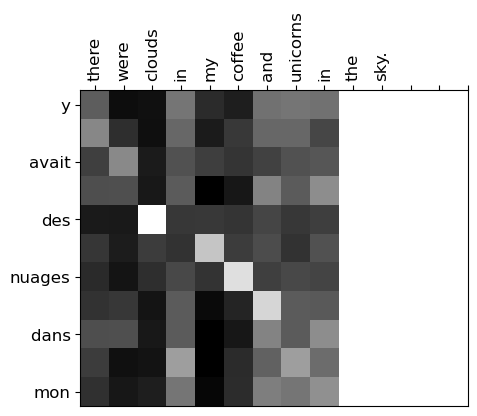

In [8]:
sentence_en = "there were clouds in my coffee and unicorns in the sky."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "il y avait des nuages ​​dans mon café et des licornes dans le ciel."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)

alignment = calc_weights(embedded_fr, embedded_en)
# visualize weights
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(alignment,cmap='gray')
ax.xaxis.tick_top()
# ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticks(np.arange(len(sentence_en.split(' '))))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=12);
ax.set_xticks(np.arange(len(sentence_fr.split(' '))));
ax.set_yticklabels(sentence_fr.split(" "), size=12);

# Compute the top-2 alignments for each French word
top_2_alignments = []
# top_2_alignments = np.argsort(alignment, axis=0)[-2:]

for row in alignment:
    # argsort returns indices of elements sorted in ascending order, so take the last two for the largest values
    top_indices = row.argsort()[-2:][::-1]  # Reverse to get largest first
    top_2_alignments.append(top_indices)

# Display the top-2 alignments
for i, indices in enumerate(top_2_alignments):
    french_word = sentence_fr.split(" ")[i]
    # english_words = [sentence_en.split(" ")[index] for index in indices]
    # print(f"French word '{french_word}' aligns with English words: {english_words}")

    aligned_english_words = [sentence_en.split(" ")[j] for j in indices]
    print(f"French word '{french_word}' is most aligned with English words: {aligned_english_words}")



1. What are the top 2 alignments shown in the figure?
2. On the rows you see flat lines for `ciel` and `dans` and `licornes`, why do you think that is?

**Answer:**

```
Answer 1. 
The top 2 alignments for each French word are determined based on the highest values in the alignment matrix. 
like there are strong associations for the words "nuages" and "il".
Answer 2. 
The flat lines for 'ciel', 'dans', and 'licornes' indicate that these French words are not strongly aligned with any specific English word in the given context. This could be due to several reasons:

- Lack of direct translation equivalents
- Polysemy or multiple meanings
In summary, the flat lines suggest that the alignment model has difficulty establishing strong associations between certain French words and their corresponding English counterparts, possibly due to translation complexities or lack of direct correspondence.
```

####${\color{red}{Comments\ 3.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section|
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Scaled Dot-product
Implement the scaled dot-product attention using the functions from above.



In [12]:
import torch.nn.functional as F

def attention(queries, keys, values):
    """
    Scaled dot-product attention
    
    Parameters:
        queries: Query matrix
        keys: Key matrix
        values: Value matrix
    
    Returns:
        attention: Attention matrix
    """
    # Convert NumPy arrays to PyTorch tensors
    queries = torch.tensor(queries)
    keys = torch.tensor(keys)
    values = torch.tensor(values)
    
    # Calculate the dot product of queries and keys
    dot_product = torch.matmul(queries, keys.transpose(-2, -1))

    # Scale the dot product
    scaled_dot_product = dot_product / torch.sqrt(torch.tensor(queries.size(-1)).float())

    # Apply softmax to obtain attention weights
    attention_weights = F.softmax(scaled_dot_product, dim=-1)

    # Calculate the weighted sum using the attention weights
    attention_w = torch.matmul(attention_weights, values)

    return attention_w


attention_result = attention(embedded_fr, embedded_en, embedded_en)
print(attention_result.shape)
print(attention_result[0:2,:10])

torch.Size([11, 300])
tensor([[-0.0095, -0.0042, -0.0182,  0.0725, -0.0279, -0.0102,  0.0010, -0.0457,
          0.0331,  0.0656],
        [-0.0095, -0.0041, -0.0183,  0.0725, -0.0279, -0.0102,  0.0010, -0.0457,
          0.0331,  0.0657]], dtype=torch.float64)


####${\color{red}{Comments\ 3.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$